# Homework information


**Students:** Черкашина Елизавета Андреевна, Мешков Михаил Алексеевич

**Master’s programme:** Data Analytics and Social Statistics

**Task:**  Module 2. Hard skills project № 4 `Text analysis'

**Date:** 17.12.2024  

## Import libraries

In [1]:
#import libraries
import pandas as pd
from matplotlib import pyplot as plt
import spacy
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
import nltk
import re
import string
import numpy as np
import warnings
# disable warnings 
warnings.filterwarnings("ignore")
# making ggplot style
plt.style.use('ggplot')

## Task №1

### 1.1 Load "text" and "target" columns to pandas. 

In [2]:
# import data
data = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding='latin-1', 
                 names = ["target", "ids", "date", "flag", "user", "text"])

In [3]:
# checking informathion about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


**Conclusion:**  data loaded correctly and contain and information same as at the description.


In [4]:
# filter the columns we'll be working with
data_filtered = data[["target", "text"]]
# filter the random 1000 rows and making final df for work
df = data_filtered.sample(n=1000, random_state=42425).reset_index(drop=True)
# take a look at final df
df.head()

,target,text
0,4,Going to pic quick join?
1,0,urg. i should be somewhere I really want to b...
2,4,Help me!!! Chanting NO CAKE NO CAKE!! LOL BD ...
3,0,"@AritheGenius Awww, we still love you though EB"
4,4,trying to find my life again


**Conclusion:**  data frame for work have been made.

### 1.2 Compute average text length, and dictionary size. 

In [5]:
# load model
nlp = spacy.load("en_core_web_trf")

In [6]:
# making anonymous function to find tokens
df['tokens'] = df['text'].apply(lambda x: [token.text.lower() 
                                           for token in nlp(x) 
                                           if token.is_alpha])

# calculate average text length
total_length = df['tokens'].apply(len).sum()
average_length = total_length / len(df)

# finding unique tokens
unique_tokens = set(token for tokens in df['tokens'] for token in tokens)
dictionary_size = len(unique_tokens)

In [7]:
print ("\033[1mConclusion:\033[0m")
print(f"Average text length: {average_length:.2f} tokens")
print(f"Dictionary size: {dictionary_size} tokens")

Conclusion:
Average text length: 11.97 tokens
Dictionary size: 2914 tokens


## Task №2

In this section we are conducting our sentiment analysis. We chose to use the 
textblob pretrained model and preprocessed the data with spacy. 
We use textblob to produce negative/positive sentiment classification, 
which correlates well with our "target" column for easier comparison later on. 
Compared to some tools for sentiment analysis from spacy or other packages, 
this model is usually more accurate and convenient to use.

For this task and tasks 6 and 7 we are preprocessing our tweets since the 
functions used for these tasks do not perform these changes automatically. This
is needed because tweets have a lot of special characters and words that are
difficult for the model to interpret.

In [8]:
# preprocessing
# !for first use, uncomment these commands!
#nltk.download('stopwords')
#nltk.download('punkt', force=True)
#nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

def preprocess_tweet(tweet):
    # removing URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    # removing mentions and hashtags
    tweet = re.sub(r"@\w+|#\w+", "", tweet)
    # removing punctuation and special characters
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    # removing numbers
    tweet = re.sub(r"\d+", "", tweet)
    # converting text to lowercase
    tweet = tweet.lower()
    # tokenizing the tweet
    words = tokenizer.tokenize(tweet)
    # removing stopwords and lemmatize words
    processed_words = [
        lemmatizer.lemmatize(word) for word in words \
        if word not in stop_words and len(word) > 1
    ]
    # joining words back into a single string
    return " ".join(processed_words)

df["processed_text"] = df["text"].apply(preprocess_tweet)

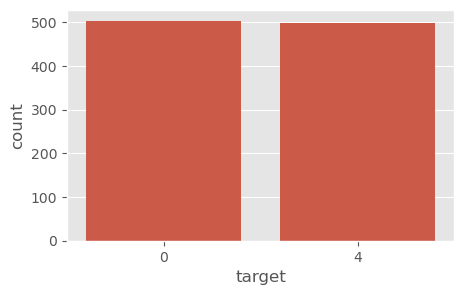

In [9]:
# target column values (sentiment) count 
plt.figure(figsize=(5, 3))
sns.countplot(x='target', data=df)
plt.show()

As we can see from the graph, the dataset has no tweets with neutral (target=2)
sentiment. Thus, our model will be classifying tweets as positive and negative.

In [10]:
# spacy/textblob sentiment analysis

# sentiment classification function
def get_sentiment(tweet):
    # textblob for sentiment polarity
    blob = TextBlob(tweet)
    polarity = blob.sentiment.polarity  # polarity range is from -1 to 1 
    if polarity > 0:
        return "Positive"
    else:
        return "Negative"

# applying sentiment function
df["sentiment"] = df["processed_text"].apply(get_sentiment)

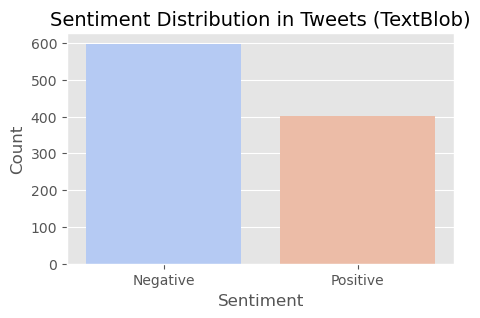

In [11]:
# sentiment distribution for TextBlob results
# number of tweets of each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Plot the sentiment distribution using a bar chart
plt.figure(figsize=(5, 3))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, 
            palette="coolwarm")
plt.title("Sentiment Distribution in Tweets (TextBlob)", 
          fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

From the graph we can see that the model classified more tweets as negative,
while the target-indicated sentiments have almost equal number of negative and 
positive tweets. This gives us an idea that the model did not perform perfectly,
which we will check in the next section.

## Task №3

In this part we are comparing our model's sentiment analysis results with the
"target" column provided in the original dataset. While the "target" column can
have three possible values: 0 for negative, 2 for neutral, and 4 for positive 
tweets, in fact there are only negative and positive tweets, as discussed in the
previous section.

In [12]:
# mapping target numeric values 
sentiment_mapping = {0: "Negative", 4: "Positive"}
df["target_map"] = df["target"].map(sentiment_mapping)

# comparing sentiment results to the target
accuracy = accuracy_score(df["target_map"], df["sentiment"])
print(f"Accuracy: {accuracy * 100:.2f}%")

# report on accuracy
report = classification_report(
    df["target_map"], 
    df["sentiment"], 
    target_names=["Negative", "Positive"]
)
print("\nClassification Report:\n", report)

Accuracy: 60.90%

Classification Report:
               precision    recall  f1-score   support

    Negative       0.59      0.71      0.64       503
    Positive       0.63      0.51      0.57       497

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.60      1000
weighted avg       0.61      0.61      0.61      1000



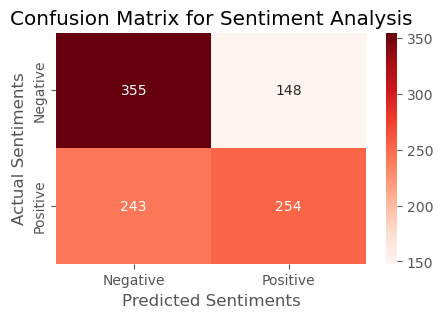

In [13]:
# confusion matrix
conf_matrix = confusion_matrix(df["target_map"], df["sentiment"], 
                               labels=["Negative", "Positive"])
conf_labels = ["Negative", "Positive"]

# Visualizing the Confusion Matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", 
            xticklabels=conf_labels, yticklabels=conf_labels)
plt.xlabel("Predicted Sentiments")
plt.ylabel("Actual Sentiments")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

Overall, the accuracy of the model's analysis is around 60%.
Based on the results we can conclude that the model is moderately accurate with
negative and positive sentiment classification. This can be explained by the 
fact that vocabulary that people use on social media and on twitter specifically
can be very different from the vocabulary used in the data that was used to 
train the model.

## Task №4

For finding all persons and organizations in positive tweets, we will use spaCy.

The spaCy model "en_core_web_sm" contains information about entities. 
By using it, we can find organizations or persons in tweets.

In [14]:
# filter df by only positive tweets
df_pos = df[df["sentiment"] == "Positive"]

In [15]:
def entities_in_texts(df):
    # list to store new rows
    expanded_rows = []
# iterate over each row in the df
    for _, row in df.iterrows():
        text = row['text']  # extract text from the current row
        doc = nlp(text)     # process the text with the NLP model
# find entities in the processed text
        for ent in doc.ents:
            # check if the entity is an organization or a person
            if ent.label_ == "ORG" or ent.label_ == "PERSON":
                # create a new row for each entity found
                expanded_rows.append({
                    'target': row['target'],  
                    'text': text,             
                    'tokens': row['tokens'],  
                    'sentiment': row['sentiment'],  
                    'entity': ent.text,       
                    'entity_type': ent.label_ 
                })

    # create a new df from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df  # return the new DataFrame

# call the function and create a new df with entities
df_entities = entities_in_texts(df_pos)
df_entities[["entity","entity_type"]].head() # display the new df

,entity,entity_type
0,urg,PERSON
1,BD,ORG
2,@AritheGenius,PERSON
3,EB,PERSON
4,@mitchelmusso,PERSON


**Conclusion:**
1. The spaCy model "en_core_web_trf" could find entities in tweets, but it doesn't do it really good.
2. The reason why this model is not good for working with tweets could be that tweets are written in a specific language, while this model is not designed for specific textsts.
3. Therefore, for working with tweets, it is better to use specialized models or train such models yourself.


## Task №5

For find most friquent organizations and persons in positive
tweets lets  use pandas and counter.


In [16]:
# most friquent organizations
df_entities[df_entities['entity_type'] == 'ORG'] \
['entity'].value_counts().head(5)

entity
Twitter        2
BD             1
@oziangie      1
UP             1
BBC iPlayer    1
Name: count, dtype: int64

In [17]:
# most friquent persons
df_entities[df_entities['entity_type'] == 'PERSON'] \
['entity'].value_counts().head(5)

entity
@stephenfry       2
@jesseowen        1
@fraseredwards    1
Gary              1
alison            1
Name: count, dtype: int64

**Conclusion:**
1. The most friquent ORG is Twitter
2. The most friquent Person is @stephenfry  
3. Some entities could be recognized with mistakes (e.g., 'urg', 'shell', etc.) because it is not specific to Twitter language.

## Task №6

In this section we are going to perform k-means clustering of tweets with 
negative sentiments and use tf-idf function to rank important phrases.

In [18]:
# filtering out positive tweets
neg_tweets = df[df["sentiment"]=="Negative"]["processed_text"]


In [19]:
# converting the documents to a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(neg_tweets)

print("TF-IDF Matrix Shape:", X.shape)  # the shape of the matrix

TF-IDF Matrix Shape: (598, 1696)


Before we do clustering we need to determine an optimal number of clusters (k) 
by the elbow method.

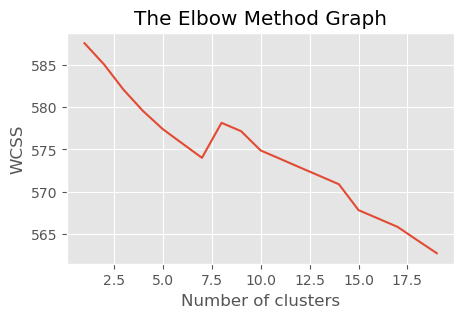

In [20]:
number_of_clusters=20
wcss=[] # within-cluster sum of squares
for i in range(1,number_of_clusters): 
     kmeans = KMeans(n_clusters=i, random_state=0)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)

# plot the elbow 
plt.figure(figsize=(5, 3))
plt.plot(range(1, number_of_clusters), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Based on the graph above, we see an "elbow" at around k=6, after which the rate
of change becomes smaller, so our best-fitting k is equal to 6.

In [21]:
# performing k-means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

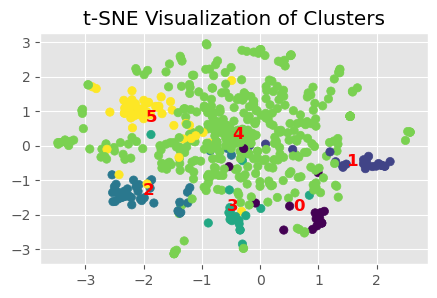

In [22]:
# reduce dimentionality for plotting
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# plotting the clusters
plt.figure(figsize=(5, 3))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', marker='o')

# calculating the centroids of each cluster in the t-SNE space
unique_labels = np.unique(labels)
for cluster_label in unique_labels:
    cluster_points = X_tsne[labels == cluster_label]  # Points in the cluster
    centroid = cluster_points.mean(axis=0)  # Compute centroid
    plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, 
             fontweight='bold', ha='center', va='center', color='red')

plt.title('t-SNE Visualization of Clusters')
plt.show()

Looking at the graph we can see that the yellow cluster is dispersed, likely 
suggesting that there are a low of tweets sharing a general sentiment/topic. 
There are also clusters that are more defined which means they share more 
similarities between each other.

## Task №7

In [23]:
def get_top_keywords(n_terms):
    # groups the TF-IDF vector by cluster
    df = pd.DataFrame(X.todense()).groupby(labels).mean() 
    # access tf-idf terms
    terms = vectorizer.get_feature_names_out() 
    # for each row, find the n terms that have the highest tf idf score
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) 
            
get_top_keywords(10)


Cluster 0
cincinnati,slang,mandy,understood,moore,right,come,swamped,year,wish

Cluster 1
home,tsk,buddy,babbbyyy,mcfly,honey,house,time,ill,miss

Cluster 2
rainy,hard,busy,need,school,till,today,bad,twitter,day

Cluster 3
flight,bread,night,morning,office,got,raining,today,tomorrow,work

Cluster 4
time,think,got,make,going,feel,dont,want,like,know

Cluster 5
come,tired,hungry,bored,sleep,hear,sick,sad,sorry,im


The dispersed cluster (5) has words such as make/feel/like that are often used
to express anything, including negative sentiments. Other clusters present words
that are less used in general and are more specific, this explains why we have
one very disperesed cluster and other more tightly packed clusters. Another 
point to note is that the top words in clusters cannot be summarised easily,
thus it is hard to describe each cluster by one specific topic that is the most 
reccurent. This can be explained by the nature of tweets where people can be 
negative about so many different things that it becomes difficult to capture.

## Conclusions

To summarise our project's findings, text analysis is heavily reliant on tools
suitable for particular purposes. Although preprocessing can help increase the 
quality of the analysis, the model and the data it was trained on also plays an
important role. On the example of the tweets dataset we can see that models made
for general text analysis are not as accurate with the unique language that is 
being used on social media, twitter especially. Moreover, regular procedures and
tools used to preprocess the text might not work as well as expected due to such
unique vocabulary and signs used to convey meaning and sentiment on social media. 
The main outtake is that for the purpose as specific as analysing tweets it is
better to use models made specifically for that, although it is worth mentioning 
that common text analysis models do a decent enough job and can give a general
understanding of what is going on in the dataset. 